This notebook constitutes the initial modeling stage of the project. Its primary purpose is to establish robust,
well-documented baseline models against which more sophisticated architectures (e.g. LSTM or TFT networks)
can subsequently be compared.

The main steps are:

1. Load the pre-processed train, validation and test datasets.
2. Specify the explanatory variables (features) and the response variable (binary target).
3. Train a regularized Logistic Regression model using standardized features.
4. Train an XGBoost classifier capable of capturing non-linear relationships.
5. Evaluate both models on train, validation and test sets using a coherent set of metrics.
6. Persist the trained models and their evaluation metrics to disk (`models/` and `reports/` folders).

No time-series windowing or sequence models are considered in this notebook; those will be introduced in a
subsequent modeling stage dedicated specifically to recurrent neural networks.

# 0. Imports and global configuration


In [16]:
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay,
)

from xgboost import XGBClassifier, callback

from src.utils.config import load_config
from src.processing.windowing import build_windows_from_df
cfg = load_config()

MODELS_DIR = PROJECT_ROOT / "models"
REPORTS_DIR = PROJECT_ROOT / "reports"
PROC_DATA_DIR = PROJECT_ROOT / "data" / "processed"

REPORTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

TARGET_COL = "target"
RANDOM_SEED = 42


Para usar windowing, hacer algo como lo siguiente:

````
from src.processing.windowing import build_windows_from_df

train = pd.read_parquet("data/processed/train.parquet")
val   = pd.read_parquet("data/processed/val.parquet")
test  = pd.read_parquet("data/processed/test.parquet")

WINDOW_SIZE = 60
TARGET_COL = "BinaryTarget"

X_train, y_train, feature_cols = build_windows_from_df(
    train, target_col=TARGET_COL, window_size=WINDOW_SIZE
)
# Para val/test usas las MISMAS feature_cols
from src.processing.windowing import build_windows

X_val, y_val = build_windows(val, feature_cols, TARGET_COL, WINDOW_SIZE)
X_test, y_test = build_windows(test, feature_cols, TARGET_COL, WINDOW_SIZE)

```

---
# 1. Load processed datasets

In [18]:
train = pd.read_parquet(PROC_DATA_DIR / "train.parquet")
test = pd.read_parquet(PROC_DATA_DIR / "test.parquet")
val = pd.read_parquet(PROC_DATA_DIR / "valid.parquet")

print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)

Train shape: (1644, 73)
Validation shape: (757, 73)
Test shape: (752, 73)


---
# 2. Feature and target definition

In [19]:
# we take all numeric columns
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()

# features = all numeric except the target
feature_cols = [c for c in numeric_cols if c != TARGET_COL]

print("number of features:", len(feature_cols))

# build X and y for each split 
# TODO: creo que aqui puedo añadir alguna funcion de windowing.py
X_train, y_train = train[feature_cols].values, train[TARGET_COL].values
X_val, y_val = val[feature_cols].values, val[TARGET_COL].values
X_test, y_test = test[feature_cols].values, test[TARGET_COL].values


number of features: 72


---
# 3. Target balance inspection

In [20]:
def class_ratio(y):
    """Just show how many 0s and 1s we have in percentage"""
    return pd.Series(y).value_counts(normalize=True).rename("ratio")

print("Train target ratio:")
display(class_ratio(y_train).to_frame("train"))

print("Valid target ratio:")
display(class_ratio(y_val).to_frame("val"))

print("Test target ratio:")
display(class_ratio(y_test).to_frame("test"))

Train target ratio:


,train
0,0.506083
1,0.493917


Valid target ratio:


,val
1,0.519155
0,0.480845


Test target ratio:


,test
0,0.515957
1,0.484043


---
# 4. Unified Evaluation Utility
(definition of the evaluation function)

In [21]:
def evaluate_classifier(model, X_tr, y_tr, X_te, y_te, model_name, plot_roc=False):
    """
    Small helpers. It takes a model, training data and test data, 
    and gives back a bunch of metrics in one dict.
    """
    # predicted probs for class 1 (positive class)
    proba_tr = model.predict_proba(X_tr)[:,1]
    proba_te = model.predict_proba(X_te)[:,1]

    # hard predictions with 0.5 threshold
    pred_tr = (proba_tr >= 0.5).astype(int)
    pred_te = (proba_te >= 0.5).astype(int)

    metrics = {}

    for split, y_true, y_pred, y_proba in [
        ("train", y_tr, pred_tr, proba_tr),
        ("test", y_te, pred_te, proba_te)
    ]:
        metrics[(model_name, split, "auc")] = roc_auc_score(y_true, y_proba)
        metrics[(model_name, split, "accuracy")] = accuracy_score(y_true, y_pred)
        metrics[(model_name, split, "precision")] = precision_score(y_true, y_pred, zero_division=0)
        metrics[(model_name, split, "recall")] = recall_score(y_true, y_pred, zero_division=0)
        metrics[(model_name, split, "f1")] = f1_score(y_true, y_pred, zero_division=0)

    if plot_roc:
        RocCurveDisplay.from_predictions(y_te, proba_te)
        plt.title(f"ROC - {model_name} (test)")
        plt.show()

    return metrics


---
# 5. Baseline Model I: Logistic Regression

## 5.1. Model construction

In [22]:
logreg_clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l2",
            C=1.0,
            solver="lbfgs",
            max_iter=10_000,
            random_state=RANDOM_SEED,
            verbose=1,
        )),
    ]
)

## 5.2. Training

In [23]:
logreg_clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


## 5.3. Evaluation

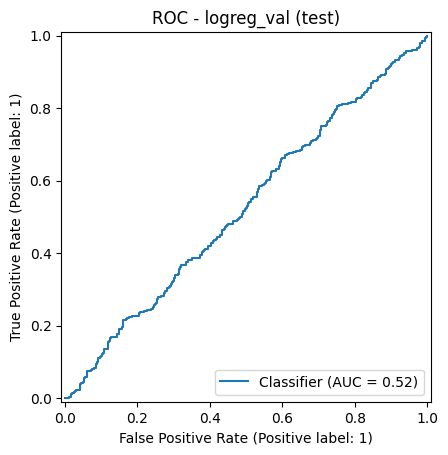

{('logreg_val', 'train', 'auc'): 0.6184160666919287,
 ('logreg_val', 'train', 'accuracy'): 0.5881995133819952,
 ('logreg_val', 'train', 'precision'): 0.5873221216041398,
 ('logreg_val', 'train', 'recall'): 0.5591133004926109,
 ('logreg_val', 'train', 'f1'): 0.5728706624605678,
 ('logreg_val', 'test', 'auc'): 0.5242009898498448,
 ('logreg_val', 'test', 'accuracy'): 0.49801849405548215,
 ('logreg_val', 'test', 'precision'): 0.5305164319248826,
 ('logreg_val', 'test', 'recall'): 0.2875318066157761,
 ('logreg_val', 'test', 'f1'): 0.37293729372937295}

In [72]:
logreg_metrics_val = evaluate_classifier(
    logreg_clf,
    X_train, y_train,
    X_val, y_val,
    model_name="logreg_val",
    plot_roc=True,
)


logreg_metrics_val

CLEARLY THERE IS LEAKAGE SOMEWHERE!!!
probablemente porque el BinaryTarget está construido con el return de hoy, no de ayer.

---
# 6. Baseline Model II: XGBoost Classifier

## 6.1. Model construction

In [77]:
xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metrics="logloss",
    n_jobs=-1,
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=RANDOM_SEED,
)

## 6.2. Training

In [79]:
early_stop = callback.EarlyStopping(
    rounds=20,
    metric_name="logloss",
    data_name="validation",
    save_best=True
)

xgb_clf.fit(X_train, y_train)

/Users/jenriquezafra/Proyectos/Dev/python/Equity-Signals/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:18:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "eval_metrics" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## 6.3. Evaluation

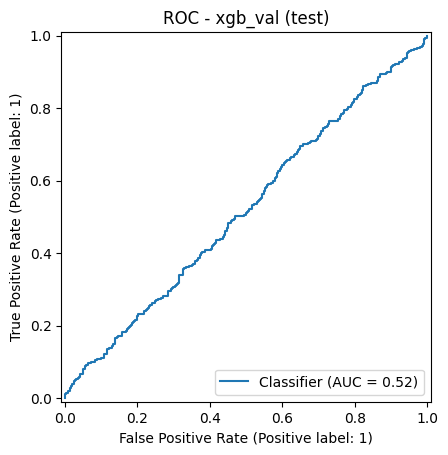

{('xgb_val', 'train', 'auc'): 1.0,
 ('xgb_val', 'train', 'accuracy'): 0.9993917274939172,
 ('xgb_val', 'train', 'precision'): 0.998769987699877,
 ('xgb_val', 'train', 'recall'): 1.0,
 ('xgb_val', 'train', 'f1'): 0.9993846153846154,
 ('xgb_val', 'test', 'auc'): 0.5181262757598636,
 ('xgb_val', 'test', 'accuracy'): 0.5072655217965654,
 ('xgb_val', 'test', 'precision'): 0.5245098039215687,
 ('xgb_val', 'test', 'recall'): 0.544529262086514,
 ('xgb_val', 'test', 'f1'): 0.5343320848938826}

In [80]:
xgb_metrics_val = evaluate_classifier(
    xgb_clf,
    X_train, y_train,
    X_val, y_val,
    model_name="xgb_val",
    plot_roc=True,
)

xgb_metrics_val

---
# 7. Metrics and Export

---
# 8. Model serialization
- save logistic regression model
- save XGBoost model

---
# 9. Placeholder for Sequence Models (LSTM or even TFT)
